# Car Evaluation Classification

Author: Matthew Carter

## Introduction

In this machine learning project I will be using the Car Evaluation Data Set from the __[UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Car+Evaluation)__ . I will use a simple random forest classifier to try to predict car acceptibility using a number of features such as its overall price and maintenance cost. Once a basic model has been created I will look at what impact leveraging the ordinality of the data and feature selection have on the model accuracy.

## Part One

### Importing the dataset

I'll begin by importing the raw data into a Pandas DataFrame and taking an intial look at what it includes.

In [1]:
# Common Python packages that will be used throughout project.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# List of column names. A header needs to be added because the raw data does not contain one.
col_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
# Create DataFrame from the dataset.
df = pd.read_csv('car.data.csv', header=None, names=col_names)

In [3]:
# Display the first five rows of the DataFrame.
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


The columns represent the following:
- buying - price of the car
- maint - price of maintenance
- doors - number of doors
- persons - highest number of passengers that can be transported
- lug_boot - size of luggage compartment/boot
- safety - estimated safety of car
- class - car acceptibility

In [4]:
# Get a summary of the DataFrame.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
buying      1728 non-null object
maint       1728 non-null object
doors       1728 non-null object
persons     1728 non-null object
lug_boot    1728 non-null object
safety      1728 non-null object
class       1728 non-null object
dtypes: object(7)
memory usage: 94.6+ KB


In this dataset there are 1728 rows of data with no missing data entries. All seven columns are currently object data types, which are essentially strings. While converting the columns from Pandas object to Pandas category data types would save memory (although it makes little difference for this small dataset) and indicate to other Python libraries the true data type, there is little reason to do so because the data will be encoded for use in the machine learning model.

Now to identify the different values in each feature column and the label column.

In [5]:
# Get a count of the number of unique values for each feature column in the DataFrame.
feature_names = list(df.columns.values[:-1])
for feature in feature_names:
    unique_count = df[feature].nunique()
    unique_vals = df[feature].unique()
    print("{}: {} values, {}".format(feature, unique_count, unique_vals))

buying: 4 values, ['vhigh' 'high' 'med' 'low']
maint: 4 values, ['vhigh' 'high' 'med' 'low']
doors: 4 values, ['2' '3' '4' '5more']
persons: 3 values, ['2' '4' 'more']
lug_boot: 3 values, ['small' 'med' 'big']
safety: 3 values, ['low' 'med' 'high']


All feature columns contain ordinal data with three or four unique values. Ordinal data is similar to categorical data in that there are a small, fixed number of values, but the difference is that ordinal data has a clear ordering to it. 

In [6]:
# Get a count of the number of unique values for the label column.
label_name = df.columns.values[-1]
print("{}: {} values, {}".format(label_name, df[label_name].nunique(), df[label_name].unique()))

class: 4 values, ['unacc' 'acc' 'vgood' 'good']


There are four unique values in the label column and like the feature columns they are ordinal.

In [7]:
# Display total counts for each of the unique values in the label column.
df[label_name].value_counts()

unacc    1210
acc       384
good       69
vgood      65
Name: class, dtype: int64

This dataset is clearly dominated by unacceptable cars!

### Encoding the data

As shown above each column contains ordinal data. Ordinal data is categorical data which has some natural ordering (e.g. in the buying column the values range from low to vhigh). However in order for the model algorithm to use the data it needs to be in numerical form and this is achieved through encoding. 

Initially I will perform a standard encoding on the feature columns (X values in the model) and the label column (y values in the model), but will not take advantage of the data's ordinality in the model. Each feature column containing k categories, will result in k-1 dummy variable columns once encoded. This is because k-1 dummy variables are needed to capture all the information about a given feature. For example there are four variables in the buying column, so three dummy variables (4-1) are required to capture all the information. So if there are dummy columns representing low, med and high and none of them are marked as representing the original feature's value, then it implies that the value must have been vhigh.

Each dummy variable column is a binary vector containing just zeros and ones. For each observation/row in the DataFrame just one dummy variable column contains a one value, that which represents the categorical variable. The remaining dummy variable columns values for that observation are zero. This is known as one hot encoding.

In [8]:
# Create dummy columns for the categorical features. The drop_first parameter takes care of the k-1 explained above.
df_encoded = pd.get_dummies(df, columns=feature_names, drop_first=True)
df_encoded.tail()

,class,buying_low,buying_med,buying_vhigh,maint_low,maint_med,maint_vhigh,doors_3,doors_4,doors_5more,persons_4,persons_more,lug_boot_med,lug_boot_small,safety_low,safety_med
1723,good,1,0,0,1,0,0,0,0,1,0,1,1,0,0,1
1724,vgood,1,0,0,1,0,0,0,0,1,0,1,1,0,0,0
1725,unacc,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0
1726,good,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1
1727,vgood,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0


In [9]:
# Encode the class column. The class column contains the labels.
# class_uniques will be used later to map the predicted classes back into the original labels for easier interpretation. 
df_encoded['class'], class_uniques = pd.factorize(df_encoded['class'])
df_encoded.tail()

,class,buying_low,buying_med,buying_vhigh,maint_low,maint_med,maint_vhigh,doors_3,doors_4,doors_5more,persons_4,persons_more,lug_boot_med,lug_boot_small,safety_low,safety_med
1723,3,1,0,0,1,0,0,0,0,1,0,1,1,0,0,1
1724,2,1,0,0,1,0,0,0,0,1,0,1,1,0,0,0
1725,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0
1726,3,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1
1727,2,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0


Following the encoding process, the class column is first in the DataFrame instead of being the last. For readability it makes sense to move it back to its logical position as the last column. 

In [10]:
# Save the class column as a Pandas Series.
class_col = df_encoded['class']
# Remove class column from DataFrame.
df_encoded.drop(columns=['class'], inplace=True)
# Get the position of where the last column will be inserted.
last_col_pos = df_encoded.columns.get_loc('safety_med') + 1
# Insert the class column back into the DataFrame.
df_encoded.insert(last_col_pos, 'class', class_col)
df_encoded.tail()

,buying_low,buying_med,buying_vhigh,maint_low,maint_med,maint_vhigh,doors_3,doors_4,doors_5more,persons_4,persons_more,lug_boot_med,lug_boot_small,safety_low,safety_med,class
1723,1,0,0,1,0,0,0,0,1,0,1,1,0,0,1,3
1724,1,0,0,1,0,0,0,0,1,0,1,1,0,0,0,2
1725,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0
1726,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,3
1727,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,2


### Random forest classifiers

In this project I will be using the Random Forest algorithm, a supervised learning algorithm used widely for both regression and classification problems. Example applications in the real world include recommender systems, object detection and stock price prediction. 

As this is a classification project I will be using a random forest classifier, which is an ensemble of individial decision tree classifiers. On their own decision trees are weak learners, but a group of decision trees working together make a strong learner. This is the principal behind ensemble methods.

Decision trees start at a root node where a question is asked of the data. The tree then splits into branches (usually two) and depending on the complexity of the data each branch either leads to another internal node with a different question or a leaf node with a classification. This process continues until all branches reach a leaf node.

The entropy of a dataset is the level of randomness within it. The aim of splitting the dataset at a node is to reduce the entropy and ultimately to achieve a pure node that contains just one class. This decrease in entropy is known as infomation gain. 

Decision trees can be applied to both numerical and categorical data types. Ease of interpretability is their biggest advantage; their tendancy to overfit, a disadvantage. In short if a tree is too deep (many nodes), it can pick up on the specifics and noise in the training data. As a result when the model is applied to new data it does not perform well. Overfitting can be prevented by using model parameters such as a threshold value which specifies the acceptable impurity level of a node at which splitting stops or by specifying the number of nodes between the root and leaf nodes.

Each decision tree created by the random forest classifier algorithm trains on a random sample from the data and on random features. The algorithm takes the classifications made by each of these trees, and the one with most votes is the final prediction of the random forest algorithm. This ensemble approach improves the accuracy of the final overall classification and helps minimise the chances of an overfitted model. 

The random forest algorithm is fast, can work with large datasets and maintains its accuracy despite missing data, but unlike a single decision tree it is difficult to interpret.

### Creating the model

Now to start creating a basic model by first assigning the columns in the DataFrame to the features 'X' (independent variables) and labels 'y' (dependent variable).

In [11]:
# Features.
X = df_encoded.loc[:, 'buying_low':'safety_med']
# Labels.
y = df_encoded.loc[:, 'class']

The available data needs to be split into a training set to build the model, and a test set used to establish its accuracy.

In [12]:
from sklearn.model_selection import train_test_split

# Split the data into a training and test set with a 75%:25% split.
# The setting of the random state parameter allows for reproducability (i.e the split will always yield the same results).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Using the training set the random forest classifier can be created and trained. The random forest classifier has many hyperparameters, values that are external to the model itself (unlike the parameters which are learned through model training) and are not known prior to training. Changing these will change the model accuracy. For this project I will be using their defaults, only specifying the number of decision trees and a random state value for reproducability purposes. The aim of this project is not to tune the hyperparameters of the classifier, but to see what happens to model accuracy upon recognising that the data is ordinal and after feature selection.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create the random forest classifier using 100 decision trees.
clf = RandomForestClassifier(n_estimators=100, random_state=42)
# Train the classifier. This is where the forest of decision trees are created.
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

### Testing and evaluating the model

With the model trained it can now be used to make predictions on the test set data.

In [14]:
# Predict the test set results.
y_pred = clf.predict(X_test)
# Show first five predictions.
y_pred[0:5]

array([0, 3, 0, 1, 0], dtype=int64)

The predictions are still encoded, so to make them readable they must be converted back into their original labels. This is done by mapping the class names back onto the predictions using the class_uniques variable created by the factorize() method earlier.

In [15]:
class_uniques

Index(['unacc', 'acc', 'vgood', 'good'], dtype='object')

So 0 = unacc, 1 = acc, 2 = vgood and 3 = good. Note that this is the ordering chosen by default during the encoding of the class column and not a chosen order.

In [16]:
# Mapping back to original class names.
y_pred_labelled = class_uniques[y_pred]
# Show first five predictions.
y_pred_labelled[0:5]

Index(['unacc', 'good', 'unacc', 'acc', 'unacc'], dtype='object')

While the classifier provides a prediction for each observation in the test set, it doesn't mean that it is 100% sure.

In [17]:
# Predicted probabilities of the first five predictions.
clf.predict_proba(X_test)[0:5]

array([[0.94, 0.06, 0.  , 0.  ],
       [0.39, 0.02, 0.01, 0.58],
       [0.89, 0.11, 0.  , 0.  ],
       [0.1 , 0.54, 0.12, 0.24],
       [0.97, 0.  , 0.  , 0.03]])

The first row above is the first observation of the test set and the classifier was 94% sure that it was an unacceptable class of vehicle (class 0). In the second observation it was only 58% sure that it was a good class of vehicle (class 3).

So how accurate was this basic model?

In [18]:
from sklearn.metrics import accuracy_score

# Get the accuracy classification score.
accuracy_score(y_test, y_pred)

0.8865740740740741

The model was correct with 88.7% of its predictions. 

Though the accuracy is a useful indicator of performance, a confusion matrix can be used to delve into more detail. A confusion matrix is so named because it shows where the classifier is confused/incorrect with its predictions. Here it shows totals of the classifier's correct and incorrect predicted labels vs the actual labels for the test set. 

In [19]:
from sklearn.metrics import confusion_matrix

# Restore the class labels from encoded values back to their original strings.
y_pred = class_uniques[y_pred]
y_test = class_uniques[y_test]
# Create the confusion matrix. Setting the labels parameter sets the order of the columns and rows in the matrix.
# First row/column shows unacceptable, second row/column shows acceptable etc.
confusion_matrix(y_test, y_pred, labels=['unacc', 'acc', 'good', 'vgood'])

array([[291,   3,   0,   0],
       [ 17,  79,   6,   1],
       [  0,   9,   6,   0],
       [  0,  10,   3,   7]], dtype=int64)

The rows show the actual labels and the columns show the predicted labels. The diagonal values of the confusion matrix show the correct classifications where predictions matched actual labels, in this case 381/432. A perfect classifier would yield a diagonal matrix. 

Precision and recall are two metrics which can be obtained from the confusion matrix to evaluate the accuracy of the model classifier: 

- Precision: The proportion that is actually class X, of those identified as class X by the classifier.
- Recall: The proportion of class X identified correctly by the classifier.

The first row/column shows the actual/predicted unacceptable class labels. The precision is 94.5% (291/308) and the recall is 99% (291/294). The model classifier performed pretty well for this class.

The second row/column shows the actual/predicted acceptable class labels and the model wasn't as accurate for these. The precision is 78.2% (79/101) and the recall is 76.7% (79/103). Perhaps this is because the classifier had more unacceptable class data to train on than it did acceptable car data (around three times as many unacc cars in this dataset as shown in part one).

Precision and recall for the good car class are both 40.0%, and for the vgood class are 87.5% and 35.0% respectively. Both of these classes had significantly less data for the classifier to train on than the two already mentioned, so again these lower values might result from that.

Whether to maximise precision or recall depends on the purpose of the classifier, because an increase in one tends to result in a decrease to the other. The F1 score, the harmonic mean of precision and recall, is a compromise. Increasing the F1 score means the model classifier is improving.

In [20]:
from sklearn.metrics import classification_report

# Display the precision, recall and F1 score for each class.
print(classification_report(y_test, y_pred, labels=['unacc', 'acc', 'good', 'vgood']))

              precision    recall  f1-score   support

       unacc       0.94      0.99      0.97       294
         acc       0.78      0.77      0.77       103
        good       0.40      0.40      0.40        15
       vgood       0.88      0.35      0.50        20

   micro avg       0.89      0.89      0.89       432
   macro avg       0.75      0.63      0.66       432
weighted avg       0.88      0.89      0.88       432



## Part Two

### Ordinal data

As stated in part one each column contains ordinal data, but the previous model did not leverage this fact. I will now create a model recognising the ordinality to see if an improvement in accuracy can be achieved. To begin I'll make a copy of the original DataFrame.

In [21]:
df_ordinal = df.copy()
df_ordinal.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


Now to encode the features and label columns, implementing a logical ordering system for each.

In [22]:
# Create the new encoded columns in the DataFrame by mapping the feature and label columns with the desired order.
df_ordinal['buying_ordinal'] = df_ordinal['buying'].map({'low':0, 'med':1, 'high':2, 'vhigh':3})
df_ordinal['maint_ordinal'] = df_ordinal['maint'].map({'low':0, 'med':1, 'high':2, 'vhigh':3})
df_ordinal['doors_ordinal'] = df_ordinal['doors'].map({'2':0, '3':1, '4':2, '5more':3})
df_ordinal['persons_ordinal'] = df_ordinal['persons'].map({'2':0, '4':1, 'more':2})
df_ordinal['lug_boot_ordinal'] = df_ordinal['lug_boot'].map({'small':0, 'med':1, 'big':2})
df_ordinal['safety_ordinal'] = df_ordinal['safety'].map({'low':0, 'med':1, 'high':2})
df_ordinal['class_ordinal'] = df_ordinal['class'].map({'unacc':0, 'acc':1, 'good':2, 'vgood':3})
# Remove the original columns.
df_ordinal.drop(columns=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'], inplace=True)
# View last five rows of DataFrame.
df_ordinal.tail()

,buying_ordinal,maint_ordinal,doors_ordinal,persons_ordinal,lug_boot_ordinal,safety_ordinal,class_ordinal
1723,0,0,3,2,1,1,2
1724,0,0,3,2,1,2,3
1725,0,0,3,2,2,0,0
1726,0,0,3,2,2,1,2
1727,0,0,3,2,2,2,3


### Creating and evaluting the model

With the data processed the model can be created using the same process as before.

In [23]:
# Features.
X_ord = df_ordinal.iloc[:, :-1]
# Labels.
y_ord = df_ordinal.iloc[:, -1]
# Split the data for training and testing the classifier model.
X_ordtrain, X_ordtest, y_ordtrain, y_ordtest = train_test_split(X_ord, y_ord, test_size=0.25, random_state=42)
# Create the classifier.
clf_ord = RandomForestClassifier(n_estimators=100, random_state=42)
clf_ord.fit(X_ordtrain, y_ordtrain)
y_ordpred = clf_ord.predict(X_ordtest)

WIth the new model created how does its accuracy compare to the previous one?

In [24]:
accuracy_score(y_ordtest, y_ordpred)

0.9629629629629629

The accuracy of the model which utilised data prepared by recognising ordinality rose from 88.7% to 96.3%.

In [25]:
# The labels were specified in the mapping earlier (unacc=0, acc=1, good=2, vgood=3).
confusion_matrix(y_ordtest, y_ordpred, labels=[0, 1, 2, 3])

array([[294,   0,   0,   0],
       [  3,  91,   8,   1],
       [  0,   0,  14,   1],
       [  0,   1,   2,  17]], dtype=int64)

In [26]:
# Display the precision, recall and F1 score for each class.
print(classification_report(y_ordtest, y_ordpred, labels=[0, 1, 2, 3]))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       294
           1       0.99      0.88      0.93       103
           2       0.58      0.93      0.72        15
           3       0.89      0.85      0.87        20

   micro avg       0.96      0.96      0.96       432
   macro avg       0.86      0.92      0.88       432
weighted avg       0.97      0.96      0.96       432



This model is an improvement, as indicated by the accuracy score and the diagonal of the confusion matrix. The F1 score for all classes improved, but the good and vgood classes still trail.

## Part Three

Finally in this project I would like to see if a technique called feature selection can be used to achieve a model with good accuracy. For small datasets like this it is not expensive in terms of time or memory to use all the features to train a model, but for large sets with many more features (high dimensional sets) it is an issue. As well as helping with these problems, feature selection can also improve model accuracy and reduce the chances of overfitting by reducing the effects of data noise. It should be noted that although feature selection results in a reduction of features in the dataset, it is not the same as dimensionality reduction. The latter reduces the number of features by combining existing features to create new ones.

### Feature selection

I'll perform feature selection using the prepared ordinal DataFrame from part two. Although it already has an accuracy of 96.3% and may be hard to beat, it will be interesting to see what results can be achieved with feature selection.

As a starting point the RandomForestClassifier has an attribute that lists the importance of each feature, which in the scikit-learn package is the Gini importance by default. Essentially the gini impurity criterion of descendent nodes are less than that of their parent after a split. The sum of these decreases for each feature shows its importance.

In [27]:
# Get the column names of the ordinal DataFrame from part two (apart from last which is the label column).
feat_names = list(df_ordinal.columns.values)[:-1]
# Get the feature importances from the RandomForestClassifier attribute.
feat_importances = clf_ord.feature_importances_
# Display the importances for each feature.
for name, imp in zip(feat_names, feat_importances):
    print("{}: {}".format(name, imp))

buying_ordinal: 0.15679496973015414
maint_ordinal: 0.15363336272819894
doors_ordinal: 0.06504475841161442
persons_ordinal: 0.23122593193956503
lug_boot_ordinal: 0.08972317931508356
safety_ordinal: 0.30357779787538386


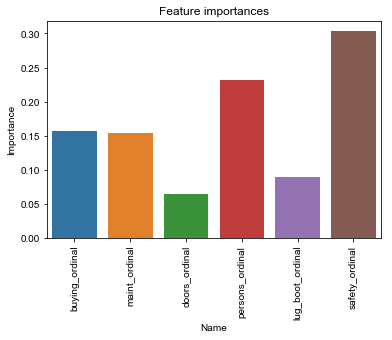

In [28]:
# Create bar plot of feature importance.
feat_imp_plot = sns.barplot(y=feat_importances, x=feat_names)
sns.set_style('darkgrid')
# Annotate plot.
plt.title("Feature importances")
plt.xlabel('Name')
plt.ylabel('Importance')
# Orientate the x-axis labels.
feat_imp_plot.set_xticklabels(feat_imp_plot.get_xticklabels(), rotation=90)
plt.show()

It appears that the car's safety (safety_ordinal), responsible for almost a third of the prediction, is the most important feature in this car evaluation dataset. The number of doors (doors_ordinal) and size of the boot (lug_boot_ordinal) are the features that have the least impact on the predictions. 

### Creating and evaluting the model

One approach to feature selection is to use a wrapper method known as backward elimination.  Wrapper methods take a selection of features from the dataset and train a model. Once evaluated, features are either added or removed to the subset and a new model is trained. Although computation time can be an issue with wrapper methods because a new model is trained to test each feature selection set, it won't be a problem with this small dataset. Starting with a full compliment of features, backward elimination involves the removal of the least important feature for each iteration of the model until a predefined condition is met.

To apply backward elimination I will use the feature importances above (feat_importances variable) to apply a series of threshold values, where only features with importance values equal to or above it are included in the model. There will be no stopping condition. Sorting feat_importances ensures that the lowest feature importance value is first (threshold lowest, all features remain) and the highest feature importance is last (threshold highest, one feature remains).

In [29]:
from sklearn.feature_selection import SelectFromModel

# Sort the threshold importances.
feat_importances.sort()
# List to store number of selected features in each model.
num_selected_features = []
# List to store the accuracy of each model.
acc_scores = []
# Create, train and evaluate the accuracy of a classifier for selected features included at each threshold value.
for importance in feat_importances:
    print("\nThreshold importance value: {}".format(importance))

    # Create a meta-transformer for selecting features equal to or above a threshold importance value.
    sfm = SelectFromModel(clf_ord, threshold=importance)
    # Fit the meta-transformer on the training data.
    sfm.fit(X_ordtrain, y_ordtrain)

    # Get an array of indices of the selected features.
    imp_feature_indices = sfm.get_support(indices=True)
    
    # Get a count of the number of selected features at this threshold value.
    selected_features_count = len(imp_feature_indices)
    # Append count to list of numbers of selected features.
    num_selected_features.append(selected_features_count)
    # Display the number of selected features.
    print("{} selected features:".format(selected_features_count))
    
    # Use the indices array to print the selected features' index in the DataFrame, name and importance value.
    for imp_feature_index in imp_feature_indices:
        imp_feature_name = df_ordinal.columns[imp_feature_index]
        imp_feature_value = sfm.estimator_.feature_importances_[imp_feature_index]
        print("Df index: {}, Feature name: {}, Importance val: {}".format(imp_feature_index, imp_feature_name, imp_feature_value))

    # Reduce the features 'X' to just the selected features.
    X_fstrain = sfm.transform(X_ordtrain)
    X_fstest = sfm.transform(X_ordtest)

    # Create the classifier and make predictions.
    clf_fs = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_fs.fit(X_fstrain, y_ordtrain)
    y_fspred = clf_fs.predict(X_fstest)

    # Calculate the accuracy of the classifier.
    acc = accuracy_score(y_ordtest, y_fspred)
    # Append accuracy score to list of accuracy scores.
    acc_scores.append(acc)
    # Display the accuracy.
    print("Accuracy: {}".format(acc))

    # Display a confusion matrix. The labels were specified in the mapping earlier (unacc=0, acc=1, good=2, vgood=3).
    print(confusion_matrix(y_ordtest, y_fspred, labels=[0, 1, 2, 3]))


Threshold importance value: 0.06504475841161442
6 selected features:
Df index: 0, Feature name: buying_ordinal, Importance val: 0.15679496973015414
Df index: 1, Feature name: maint_ordinal, Importance val: 0.15363336272819894
Df index: 2, Feature name: doors_ordinal, Importance val: 0.06504475841161442
Df index: 3, Feature name: persons_ordinal, Importance val: 0.23122593193956503
Df index: 4, Feature name: lug_boot_ordinal, Importance val: 0.08972317931508356
Df index: 5, Feature name: safety_ordinal, Importance val: 0.30357779787538386
Accuracy: 0.9629629629629629
[[294   0   0   0]
 [  3  91   8   1]
 [  0   0  14   1]
 [  0   1   2  17]]

Threshold importance value: 0.08972317931508356
5 selected features:
Df index: 0, Feature name: buying_ordinal, Importance val: 0.15679496973015414
Df index: 1, Feature name: maint_ordinal, Importance val: 0.15363336272819894
Df index: 3, Feature name: persons_ordinal, Importance val: 0.23122593193956503
Df index: 4, Feature name: lug_boot_ordina

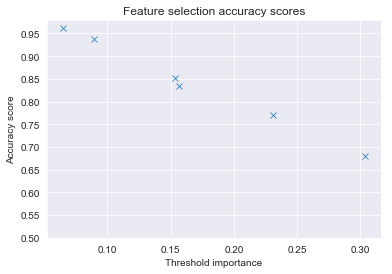

In [30]:
# Plot scatterplot with the accuracies at each threshold value.
sns.scatterplot(feat_importances, acc_scores, marker='x')
sns.set_style('darkgrid')
plt.yticks(np.arange(0.5, 1, 0.05))
plt.title("Feature selection accuracy scores")
plt.xlabel("Threshold importance")
plt.ylabel("Accuracy score")
plt.show()

This plot shows the change in model accuracy as backward elimination progresses, with the leftmost point representing the model with all features present and the rightmost point representing it with just the most important feature remaining. As features are removed the accuracy of the model reduces, almost linearly it seems.

The confusion matrices also seem to show that as the number of selected features used in training decreases, the model tends towards predicting unacceptable and acceptable car classes. With just the safety_ordinal feature in the training set, all predictions were of the unacceptable class. Again this is perhaps due to the imbalance in the dataset.

Finally the percentage fall in accuracy of each of these feature selection models from the original can be calculated.

In [31]:
# Create a new DataFrame where each row represents one of the feature selection models. 
df_fs_results = pd.DataFrame({"threshold_importance" : feat_importances, "no_selected_features" : num_selected_features, "accuracy" : acc_scores})
df_fs_results

,threshold_importance,no_selected_features,accuracy
0,0.065045,6,0.962963
1,0.089723,5,0.937500
2,0.153633,4,0.851852
3,0.156795,3,0.833333
4,0.231226,2,0.770833
5,0.303578,1,0.680556


Percentage change is calculated using the formula:

$$percentage\;change = \frac{new\;value - original\;value}{original\;value} \times 100$$

In [32]:
# Create a percentage change column in the DataFrame which shows the accuracy change of each feature selection model from the original.
df_fs_results["acc_pct_change"] = df_fs_results["accuracy"].apply(lambda x: ((x - df_fs_results["accuracy"].iloc[0])/df_fs_results["accuracy"].iloc[0]) * 100)
df_fs_results

,threshold_importance,no_selected_features,accuracy,acc_pct_change
0,0.065045,6,0.962963,0.000000
1,0.089723,5,0.937500,-2.644231
2,0.153633,4,0.851852,-11.538462
3,0.156795,3,0.833333,-13.461538
4,0.231226,2,0.770833,-19.951923
5,0.303578,1,0.680556,-29.326923


There is almost a 30% difference in accuracy between a model containing all the features and one containing only the most important. This is where a target accuracy may come into play to decide what is acceptable. For this model it is unneccesary as selecting features did not provide a more accurate model. However as stated earlier for large datasets the tradeoff between high accuracy and having a less complex model with shorter training time may be desirable.

## Conclusion

It is clear that the data preprocessing stage is very important. Recognising the ordinality in the Car Evaluation Data Set yielded a large increase in the accuracy of the random forest classifer model, rising from 88.7% to 96.3%. As the precision and recall metrics showed, a well balanced dataset for the classifier to train on for each class label is desirable.

Feature selection using threshold feature importance values saw a reduction in model accuracy as fewer features were used to train the model. Training the model on just the single most important feature gave an accuracy of 68%, almost 30% lower than the model trained on all its features. However this technique can be of use in models with much larger datasets where training time and memory are a factor.